In [1]:
# Загружаем библиотеки
import pandas as pd # Датафреймы pandas
import matplotlib.pyplot as plt # Графики
from sklearn.model_selection import train_test_split # Разделение выборки на обучающую и тестовую
from sklearn.ensemble import RandomForestRegressor # Модель случайного леса
from sklearn.preprocessing import StandardScaler # Z - масштабирование
from sklearn.ensemble import StackingRegressor # Стекинг моделей
from sklearn.linear_model import LinearRegression # Модель линейной регрессии
from sklearn.tree import DecisionTreeRegressor # Модель решающего дерева
from sklearn.neighbors import KNeighborsRegressor # Модель k-ближайших соседей
from sklearn.linear_model import RidgeCV # Кросс-валидация стека моделей

#### Загрузка и обработка данных

In [2]:
# Датасет цен на недвижимость
data = pd.read_csv('train.csv')
# Отбросим признак Id - это порядковый номер, полезной информации не несёт
data = data.drop(['Id'], axis = 1, errors = 'ignore')

In [3]:
# Находим числовые признаки, их тип не является object
numeric_features = list(data.dtypes[data.dtypes != object].index)
# Отбросим пропуски в числовых признаках
data = data.dropna(subset = numeric_features)
# МАСШТАБИРОВАНИЕ НЕ ПОЗВОЛЯЕТ ЛИНЕЙНОЙ РЕГРЕССИИ НОРМАЛЬНО РАБОТАТЬ!!!
# Выполним Z-масштабирование
# scaler = StandardScaler()
# data['numeric_features'] = pd.DataFrame(scaler.fit_transform(data[numeric_features]), index = data[numeric_features].index, columns = data[numeric_features].columns)

In [4]:
# Находим категориальные признаки по типу данных object
categorial_features = list(data.dtypes[data.dtypes == object].index)
# Используем унитарное кодирование, пропуски тоже учитываем
data = pd.get_dummies(data, columns = categorial_features, dummy_na = True)

In [5]:
# Признаки
X = data.drop(columns='SalePrice')
# Целевые значения
y = data['SalePrice']
# Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)  

#### Модель случайного леса

In [6]:
# Создаем модель RandomForest и обучаем её
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(f'Показатель точности модели случайного леса {model.score(X_test, y_test)}')

Показатель точности модели случайного леса 0.8845079681751177


In [7]:
# Получаем список весов всех признаков
features_weight = pd.Series(model.feature_importances_)
features_weight.index = pd.Series(X_train.columns)

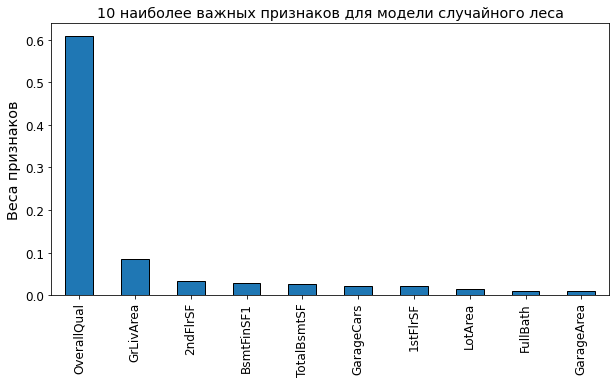

In [8]:
# Строим диаграмму весов 10 наиболее важных признаков
top_10_features = features_weight.sort_values(ascending = False).head(10)
top_10_features.plot(kind = 'bar',
                     figsize = (10, 5),
                     edgecolor = 'black',
                     fontsize = 'large'
                    )
plt.title('10 наиболее важных признаков для модели случайного леса', fontsize = 'x-large')
plt.ylabel('Веса признаков', fontsize = 'x-large') 
plt.show()

#### Стекинг моделей

In [9]:
# Создаем стэкинг из 3 моделей и обучаем его
Regressor = StackingRegressor([
                               ('LinearRegression', LinearRegression()),
                               ('KNeighborsRegressor', KNeighborsRegressor()),
                               ('RandomForest', RandomForestRegressor())
                              ], RidgeCV())
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('RandomForest', RandomForestRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [10]:
# Записываем показатели точности стекинга и отдельных моделей
result = {}
result['Стекинг моделей'] = Regressor.score(X_test, y_test)
for model in Regressor.named_estimators:
    result[model] = Regressor.named_estimators_[model].score(X_test, y_test)

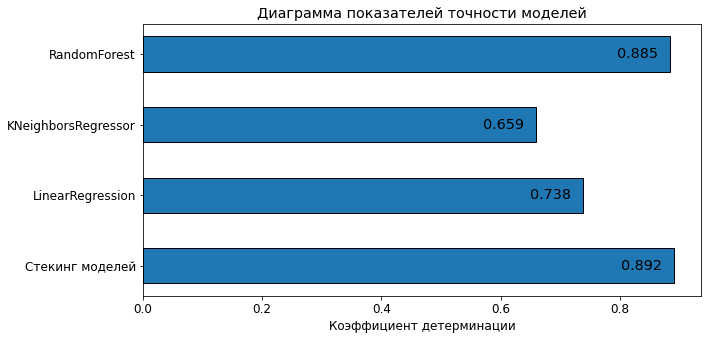

In [11]:
# Строим диаграмму показателей точности
plt.figure(figsize = (10, 5))
plt.barh(list(result.keys()),
         list(result.values()),
         height = 0.5,
         edgecolor = 'black'
        )
for model in list(result.keys()):
                  plt.text(result[model] - 0.02, 
                  model, 
                  s = round(result[model], 3), 
                  fontsize = 'x-large', 
                  verticalalignment = 'center',
                  horizontalalignment = 'right'                    
                 )
plt.title('Диаграмма показателей точности моделей', fontsize = 'x-large')
plt.xlabel('Коэффициент детерминации', fontsize = 'large')
plt.tick_params(labelsize = 'large')

plt.show()

#### Вывод: стекинг моделей позволил незначительно поднять показатель точности (примерно на 0,01)